# This is a bidirectional stacked LSTM model with 128 LSTM units in the first layer and 64 units in the second layer.
* In this model, we have two layers of Bidirectional LSTMs. The first layer has 128 LSTM units, while the second layer has 64 LSTM units. Both layers process the input sequence in both forward and backward directions, allowing the model to capture information from the entire sequence. The output from the second bidirectional LSTM layer is then passed through two dense layers to produce the final output.
# Data preparation, scaling, and LSTM model, and vizualization of model predictions



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 60, 256)          133120    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 25)                3225      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 300,723
Trainable params: 300,723


/var/folders/qx/hg7vj1615w1327p4flbrsrnm0000gp/T/ipykernel_94779/848216355.py:119: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



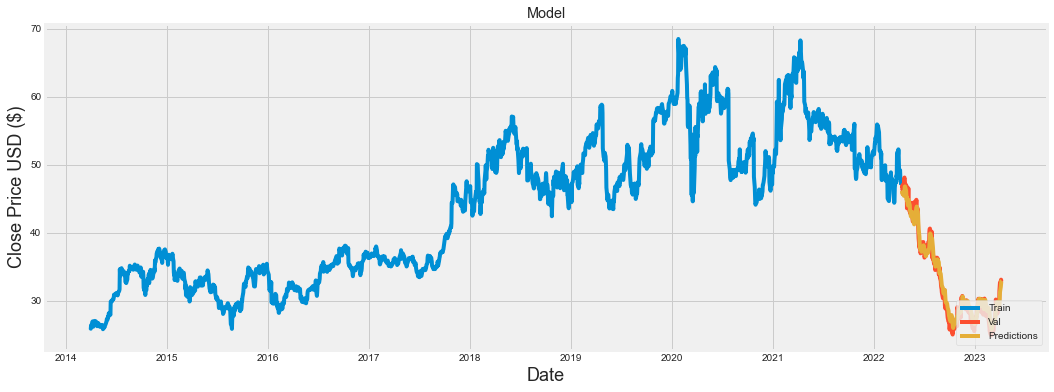

In [19]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Bidirectional


sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

yf.pdr_override()


# try with TSLA, GE, AAPL, MARA, SRPT, ABR, CENT
# The tech stocks we'll use for this analysis
tech_list = ['INTC']

# Set up End and Start times for data grab

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    
company_list = [INTC]
company_name = ["INTC"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.tail(10)

# get stock quote, specify start date ****
df = pdr.get_data_yahoo('INTC', start='2014-04-01', end=datetime.now())

# create a dataframe with close
data = df.filter(['Close'])

# convert dataframe to numpy array
dataset = data.values

# get the # of rows to train the model on, how much to save for validation ***

# 2014-04-01, and .89
training_data_len = int(np.ceil( len(dataset) * .89 ))

# scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# create the training data set 
train_data = scaled_data[0:int(training_data_len), :]

# split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
        
# convert x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# build the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(x_train.shape[1], 1)))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dense(25))
model.add(Dense(1))

model.summary()

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]

# create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# convert the data to a numpy array
x_test = np.array(x_test)

# reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))


# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()






# Actual vs predicted prices through validation period


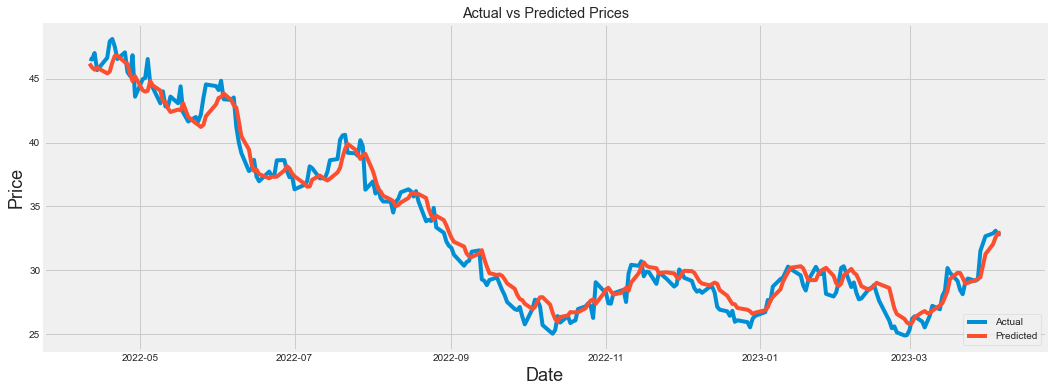

In [20]:
# create a new dataframe for comparison
compare_df = pd.DataFrame({'Date': valid.index, 'Actual': valid['Close'], 'Predicted': valid['Predictions']})
compare_df = compare_df.set_index('Date')

# plot the actual and predicted values side by side
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.plot(compare_df.index, compare_df['Actual'])
plt.plot(compare_df.index, compare_df['Predicted'])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()



## Day by day analysis, along with accuracy given by if the signs matched on a given day (increase or decrease)

In [32]:
# Create DataFrame of actual and predicted prices for each day in validation set
predictions_df = pd.DataFrame({'Date': valid.index, 
                               'Actual Close': valid['Close'], 
                               'Predicted Close': valid['Predictions'],
                               'Actual Percent Change': valid['Close'].pct_change(),
                               'Predicted Percent Change': valid['Predictions'].pct_change()})

# Create binary column for sign match
predictions_df['Sign Match'] = np.where(np.sign(predictions_df['Actual Percent Change']) == np.sign(predictions_df['Predicted Percent Change']), 1, 0)

# Calculate accuracy as the average of the Sign Match column
accuracy = predictions_df['Sign Match'].mean()

# Format numbers with two decimal places
predictions_df = predictions_df.style.format({'Actual Close': '{:.2f}', 
                                               'Predicted Close': '{:.2f}',
                                               'Actual Percent Change': '{:.2%}',
                                               'Predicted Percent Change': '{:.2%}',
                                               'Sign Match': '{:.0f}'})

# Display DataFrame and accuracy
#display(predictions_df)
print(f'Accuracy: {accuracy:.2%}')


Accuracy: 50.60%


## here is the actual strategy that goes as follows:
* if the predicted price the next day is greater, buy
* if the predicted price the next day is less, sell
* if you sell and the next say is less, hold
* if you buy and the next day is more, hold

In [33]:
actualClose = valid['Close']
predictedClose = valid['Predictions']
actualPercentChange = valid['Close'].pct_change()
predictedPercentChange = valid['Predictions'].pct_change()

initial_investment = 100
capital = initial_investment
position = 0

data = {'Date': [], 'Action': [], 'Investment': [], 'Buy & Hold': [], 'Actual Close': [], 'Predicted Close': []}

for i in range(len(predictedClose) - 1):
    if predictedClose[i] <= predictedClose[i + 1] and position == 0:
        position = capital / actualClose[i]
        capital = 0
        action = "Buy"
    elif predictedClose[i] >= predictedClose[i + 1] and position > 0:
        capital = position * actualClose[i]
        position = 0
        action = "Sell"
    else:
        action = "Hold"

    total_investment = capital + (position * actualClose[i])
    buy_and_hold = initial_investment * (actualClose[i] / actualClose[0])
    
    data['Date'].append(actualClose.index[i])
    data['Action'].append(action)
    data['Investment'].append(round(total_investment, 2))
    data['Buy & Hold'].append(round(buy_and_hold, 2))
    data['Actual Close'].append(round(actualClose[i], 2))
    data['Predicted Close'].append(round(predictedClose[i], 2))

results_df = pd.DataFrame(data)

# Apply formatting to the DataFrame
styled_results_df = results_df.style.format({'Date': '{:%Y-%m-%d}',
                                             'Investment': '{:.2f}',
                                             'Buy & Hold': '{:.2f}',
                                             'Actual Close': '{:.2f}',
                                             'Predicted Close': '{:.2f}'})

# Display the formatted DataFrame
#display(styled_results_df)

final_investment = results_df.iloc[-1]['Investment']
final_buy_and_hold = results_df.iloc[-1]['Buy & Hold']

print(f"Final Investment: {final_investment:.2f}")
print(f"Final Buy & Hold: {final_buy_and_hold:.2f}")


Final Investment: 75.62
Final Buy & Hold: 70.50


# compare the buy and hold strategy to this one

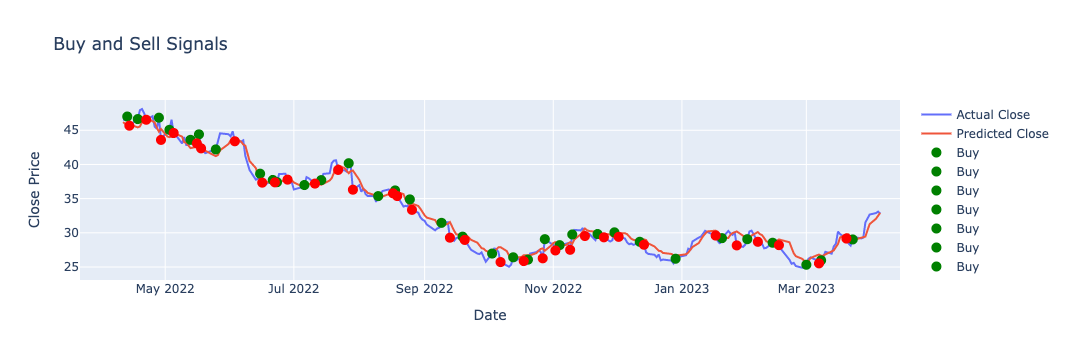

In [23]:
import plotly.offline as pyo
import plotly.graph_objs as go

# Create the actual close price trace
actual_trace = go.Scatter(x=results_df['Date'], y=results_df['Actual Close'], mode='lines', name='Actual Close')

# Create the predicted close price trace
predicted_trace = go.Scatter(x=results_df['Date'], y=results_df['Predicted Close'], mode='lines', name='Predicted Close')

# Create the buy and sell marker traces
buy_traces = []
sell_traces = []
for i, row in results_df.iterrows():
    if row['Action'] == 'Buy':
        buy_trace = go.Scatter(x=[row['Date']], y=[row['Actual Close']], mode='markers', name='Buy', marker=dict(color='green', size=10))
        buy_traces.append(buy_trace)
    elif row['Action'] == 'Sell':
        sell_trace = go.Scatter(x=[row['Date']], y=[row['Actual Close']], mode='markers', name='Sell', marker=dict(color='red', size=10))
        sell_traces.append(sell_trace)

# Combine the traces into a data list
data = [actual_trace, predicted_trace] + buy_traces + sell_traces

# Set the layout for the chart
layout = go.Layout(title='Buy and Sell Signals', xaxis_title='Date', yaxis_title='Close Price')

# Create the figure object
fig = go.Figure(data=data, layout=layout)

# Display the interactive chart in JupyterLab
pyo.iplot(fig)


# predicting tomorrows closing price

In [24]:
# Get the last 60 days of data and scale it
last_days = np.array(df['Close'][-60:]).astype(float)
last_days_scaled = scaler.transform(last_days.reshape(-1, 1))

# Reshape the data for the model
X_test = np.reshape(last_days_scaled, (1, -1, 1))

# Make a prediction
predicted_price = model.predict(X_test)

# Inverse transform the prediction to get the actual price
predicted_price = scaler.inverse_transform(predicted_price)

print("Tomorrow's predicted closing price:", predicted_price[0][0])


1/1 [==============================] - 0s 31ms/step
Tomorrow's predicted closing price: 32.903477


# predicting todays closing price

In [14]:
# Get the last 59 days of data and scale it (exclude the last day)
last_days = np.array(df['Close'][-61:-1]).astype(float)
last_days_scaled = scaler.transform(last_days.reshape(-1, 1))

# Reshape the data for the model
X_test = np.reshape(last_days_scaled, (1, -1, 1))

# Make a prediction
predicted_price = model.predict(X_test)

# Inverse transform the prediction to get the actual price
predicted_price = scaler.inverse_transform(predicted_price)

print("Today's predicted closing price:", predicted_price[0][0])


1/1 [==============================] - 0s 29ms/step
Today's predicted closing price: 31.476904


---
## in reality, past performance should not indicate future performance, 
## idiosyncratic risk...
    # company specific news
    # changes in leadership
    # mergers and acquisitions
    # industry-specific (such as tech advances)
    # global events
    
## think about the efficient market hypothesis

## should diversify investments with LSTM predictions, that way
## idiosyncratic risk can be mitigated

In [15]:
# do i want to have it change every time, or do i want to create a seed for the random
# weights in the neural network?

In [16]:
# for that, just get the news for every day on here

In [17]:
tech_list = ['TSLA', 'AAPL', 'GE', 'MARA', 'SRPT', 'ABR', 'MSFT', 'AMZN', 'JPM', 'NVDA', 'JNJ', 'IBM', 'KO', 'VZ', 'WMT', 'JPM', 'PG', 'CVX', 'PEP', 'MMM', 'XOM', 'BA', 'CSCO', 'INTC', 'RTX', 'CAT', 'GS', 'HD', 'NKE', 'DIS']

# accuracies to compare with normal

# two year predictions
## average vs actual

In [26]:
predicted = [121.572, 102.326, 108.498, 351.008, 139.328, 84.472, 102.594, 85.236, 98.616, 126.268, 88.734, 124.08, 95.968, 86.852, 107.058, 101.956, 107.898, 119.52, 89.998, 69.102, 157.068, 94.548, 86.476, 58.098, 105.698, 129.652, 144.252, 73.346, 78.634, 94.52]
actual = [75.33, 121.75, 111.38, 18.82, 189.37, 68.23, 109.57, 59.84, 83.86, 166.58, 103.25, 104.25, 117.76, 69.51, 106.79, 83.86, 110.22, 164.26, 129.04, 51.8, 205.32, 83.63, 100.35, 50.49, 126.66, 91.83, 94.97, 89.44, 90.45, 53.74]

In [27]:
print(len(predicted))
print(len(actual))

predicted_sum = sum(predicted) - 3000
actual_sum = sum(actual) - 3000

profit_loss_predicted = "Profit" if predicted_sum >= 0 else "Loss"
profit_loss_actual = "Profit" if actual_sum >= 0 else "Loss"

print(f"Net {profit_loss_predicted} from predicted values: {round(predicted_sum, 2)}")
print(f"Net {profit_loss_actual} from actual values: {round(actual_sum, 2)}")

30
30
Net Profit from predicted values: 333.38
Net Profit from actual values: 32.35


## max vs actual

In [28]:
predicted = [182.22, 115.26, 111.82, 495.98, 168.89, 89.01, 112.14, 87.28, 100.43, 155.62, 96.09, 125.99, 99.45, 93.34, 109.97, 103.97, 110.97, 122.29, 91.99, 74.47, 159.51, 101.63, 94.41, 64, 107.55, 133.48, 151.61, 76.9, 83.85, 101.24]
actual = [75.33, 121.75, 111.38, 18.82, 189.37, 68.23, 109.57, 59.84, 83.86, 166.58, 103.25, 104.25, 117.76, 69.51, 106.79, 83.86, 110.22, 164.26, 129.04, 51.8, 205.32, 83.63, 100.35, 50.49, 126.66, 91.83, 94.97, 89.44, 90.45, 53.74]

In [29]:
print(len(predicted))
print(len(actual))

predicted_sum = sum(predicted) - 3000
actual_sum = sum(actual) - 3000

profit_loss_predicted = "Profit" if predicted_sum >= 0 else "Loss"
profit_loss_actual = "Profit" if actual_sum >= 0 else "Loss"

print(f"Net {profit_loss_predicted} from predicted values: {round(predicted_sum, 2)}")
print(f"Net {profit_loss_actual} from actual values: {round(actual_sum, 2)}")

30
30
Net Profit from predicted values: 721.36
Net Profit from actual values: 32.35


## min vs actual

In [30]:
predicted = [75.56, 97.98, 103.59, 229.64, 122.38, 77.51, 93.82, 83.87, 97.48, 114.82, 85.37, 121.37, 86.93, 82.42, 103.23, 99.18, 105.1, 114.66, 88.34, 61.83, 154.32, 88.33, 79.41, 51.32, 102.06, 120.28, 137.53, 70.51, 74.14, 90.4]
actual = [75.33, 121.75, 111.38, 18.82, 189.37, 68.23, 109.57, 59.84, 83.86, 166.58, 103.25, 104.25, 117.76, 69.51, 106.79, 83.86, 110.22, 164.26, 129.04, 51.8, 205.32, 83.63, 100.35, 50.49, 126.66, 91.83, 94.97, 89.44, 90.45, 53.74]

In [31]:
print(len(predicted))
print(len(actual))

predicted_sum = sum(predicted) - 3000
actual_sum = sum(actual) - 3000

profit_loss_predicted = "Profit" if predicted_sum >= 0 else "Loss"
profit_loss_actual = "Profit" if actual_sum >= 0 else "Loss"

print(f"Net {profit_loss_predicted} from predicted values: {round(predicted_sum, 2)}")
print(f"Net {profit_loss_actual} from actual values: {round(actual_sum, 2)}")

30
30
Net Profit from predicted values: 13.38
Net Profit from actual values: 32.35


# one year predictions
## average vs actual

In [194]:
predicted = [126.698, 122.27, 167.848, 315.888, 122.752, 86.774, 91.948, 90.056, 106.626, 120.584, 80.736, 113.48, 85.362, 89.272, 98.096, 102.794, 105.65, 113.268, 88.216, 85.67, 138.544, 100.614, 89.85, 63.332, 87.366, 110.442, 133.522, 72.982, 66.358, 111.958]
actual = [56.34, 97.38, 135.68, 36, 157.58, 66.49, 96.7, 67.2, 96.2, 118.75, 92.09, 104.57, 98.42, 74.42, 97.01, 95.95, 94.84, 102.61, 106.4, 68.14, 139.52, 119.98, 98, 70.5, 96.72, 98.83, 100.24, 94.12, 96.74, 76.47]


In [195]:
print(len(predicted))
print(len(actual))

predicted_sum = sum(predicted) - 3000
actual_sum = sum(actual) - 3000

profit_loss_predicted = "Profit" if predicted_sum >= 0 else "Loss"
profit_loss_actual = "Profit" if actual_sum >= 0 else "Loss"

print(f"Net {profit_loss_predicted} from predicted values: {round(predicted_sum, 2)}")
print(f"Net {profit_loss_actual} from actual values: {round(actual_sum, 2)}")

30
30
Net Profit from predicted values: 288.96
Net Loss from actual values: -146.11


## max vs actual

In [196]:
predicted = [135.3, 126.85, 180.5, 421, 143.33, 91.55, 98.77, 92.32, 110.34, 126.17, 83.04, 118.6, 88.54, 92.24, 98.72, 107.1, 107.21, 122.84, 94.1, 89.69, 140.99, 104.4, 92.92, 66.36, 92.15, 117.43, 138.73, 77.71, 70.02, 118.03]
actual = [56.34, 97.38, 135.68, 36, 157.58, 66.49, 96.7, 67.2, 96.2, 118.75, 92.09, 104.57, 98.42, 74.42, 97.01, 95.95, 94.84, 102.61, 106.4, 68.14, 139.52, 119.98, 98, 70.5, 96.72, 98.83, 100.24, 94.12, 96.74, 76.47]


In [197]:
print(len(predicted))
print(len(actual))

predicted_sum = sum(predicted) - 3000
actual_sum = sum(actual) - 3000

profit_loss_predicted = "Profit" if predicted_sum >= 0 else "Loss"
profit_loss_actual = "Profit" if actual_sum >= 0 else "Loss"

print(f"Net {profit_loss_predicted} from predicted values: {round(predicted_sum, 2)}")
print(f"Net {profit_loss_actual} from actual values: {round(actual_sum, 2)}")

30
30
Net Profit from predicted values: 546.95
Net Loss from actual values: -146.11


## min vs actual

In [198]:
predicted = [111.72, 118.78, 160.48, 184.21, 110.84, 80.43, 84.01, 86.84, 100.9, 113.95, 78.98, 104.68, 82.17, 86.64, 97.61, 100.13, 102.07, 106.05, 84.07, 78.38, 135.41, 95.73, 87.14, 59.18, 84.22, 98.95, 127.21, 70.75, 63.81, 97.96]
actual = [56.34, 97.38, 135.68, 36, 157.58, 66.49, 96.7, 67.2, 96.2, 118.75, 92.09, 104.57, 98.42, 74.42, 97.01, 95.95, 94.84, 102.61, 106.4, 68.14, 139.52, 119.98, 98, 70.5, 96.72, 98.83, 100.24, 94.12, 96.74, 76.47]

In [199]:
print(len(predicted))
print(len(actual))

predicted_sum = sum(predicted) - 3000
actual_sum = sum(actual) - 3000

profit_loss_predicted = "Profit" if predicted_sum >= 0 else "Loss"
profit_loss_actual = "Profit" if actual_sum >= 0 else "Loss"

print(f"Net {profit_loss_predicted} from predicted values: {round(predicted_sum, 2)}")
print(f"Net {profit_loss_actual} from actual values: {round(actual_sum, 2)}")

30
30
Net Loss from predicted values: -6.7
Net Loss from actual values: -146.11
